In [1]:
# 文件路径: notebooks/d3_create_smoke_test_dataset.ipynb
# CodeGuardian: SOTA 版本 v4 - 统一数据加载，优化流程，并整合动态样本选择。

# ==============================================================================
# 步骤 1: 设置、导入与自动化路径配置
# ==============================================================================
import os
from pathlib import Path
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa
import shutil
import logging
import rootutils
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

# --- 1. 自动设置项目根目录 ---
# CodeGuardian: 这一步是核心。无论您在哪里运行这个 notebook，
# rootutils 都会找到项目根目录，加载 .env 文件，并正确设置环境变量。
try:
    root = rootutils.setup_root(__file__, indicator=".project-root", pythonpath=True, dotenv=True)
except NameError:
    root = rootutils.setup_root(search_from=".", indicator=".project-root", pythonpath=True, dotenv=True)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- 2. 路径配置 (完全自动化) ---
PROJECT_ROOT_STR = os.getenv("PROJECT_ROOT")
if not PROJECT_ROOT_STR:
    raise RuntimeError("环境变量 'PROJECT_ROOT' 未设置。请确保项目根目录有 .env 文件且内容为 'PROJECT_ROOT=${rootutils.find_root}'")
PROJECT_ROOT = Path(PROJECT_ROOT_STR)

INPUT_DATA_BASE_DIR = PROJECT_ROOT / "data/hest_hugo_6nei_correct_parquet_data"
INPUT_ARTIFACTS_DIR = INPUT_DATA_BASE_DIR / "train"
SMOKE_TEST_DIR = PROJECT_ROOT / "data/smoke_test_dataset"



In [21]:
# ==============================================================================
# 步骤 2: 一次性加载源数据 (Load Once, Use Many)
# ==============================================================================
logging.info("\n--- 步骤 2: 开始一次性加载完整的训练数据集... ---")
try:
    nodes_df = pd.read_parquet(INPUT_ARTIFACTS_DIR / "nodes.parquet")
    edges_df = pd.read_parquet(INPUT_ARTIFACTS_DIR / "edges.parquet")
    img_embeds = np.load(INPUT_ARTIFACTS_DIR / "image_embeds.npy")
    txt_embeds = np.load(INPUT_ARTIFACTS_DIR / "text_embeds.npy")
    logging.info("✅ 完整训练数据集加载完毕。")
except FileNotFoundError as e:
    logging.error(f"❌ 错误: 无法加载输入文件。请确保路径 '{INPUT_ARTIFACTS_DIR}' 正确。详细信息: {e}")
    raise



2025-11-05 08:33:05,160 - INFO - 
--- 步骤 2: 开始一次性加载完整的训练数据集... ---
2025-11-05 08:33:10,186 - INFO - ✅ 完整训练数据集加载完毕。


In [22]:
# ==============================================================================
# 步骤 3: 源数据完整性预检查
# ==============================================================================
logging.info("\n--- 步骤 3: 正在执行源数据完整性检查... ---")
# CodeGuardian: 现在我们直接操作内存中的数据，无需重复读取文件。
num_nodes = len(nodes_df)
max_tile_id = nodes_df['tile_id'].max()
num_embeddings = img_embeds.shape[0]

logging.info(f"Parquet 中的节点数量: {num_nodes}")
logging.info(f"Parquet 中的最大 tile_id: {max_tile_id}")
logging.info(f"NumPy 数组中的嵌入数量: {num_embeddings}")

if num_nodes != num_embeddings:
    raise RuntimeError(f"❌ 严重不匹配: Parquet行数 ({num_nodes}) 与 NumPy行数 ({num_embeddings}) 不同! 数据已损坏，请重新生成。")
elif max_tile_id >= num_embeddings:
    logging.warning(f"⚠️ 注意: 最大 tile_id ({max_tile_id}) 超出 NumPy 数组边界 ({num_embeddings})。这确认了 tile_id 不连续，脚本将依赖行号进行处理。")
else:
    logging.info("✅ 文件行数对齐。")



2025-11-05 08:33:22,818 - INFO - 
--- 步骤 3: 正在执行源数据完整性检查... ---
2025-11-05 08:33:22,820 - INFO - Parquet 中的节点数量: 919173
2025-11-05 08:33:22,820 - INFO - Parquet 中的最大 tile_id: 952907
2025-11-05 08:33:22,820 - INFO - NumPy 数组中的嵌入数量: 919173
2025-11-05 08:33:22,821 - WARNING - ⚠️ 注意: 最大 tile_id (952907) 超出 NumPy 数组边界 (919173)。这确认了 tile_id 不连续，脚本将依赖行号进行处理。


In [23]:
# ==============================================================================
# 步骤 4: 动态选择测试样本并准备输出目录
# ==============================================================================
logging.info("\n--- 步骤 4: 动态选择测试样本 ---")

sample_counts = nodes_df['sample_id'].value_counts().to_frame(name='count')
logging.info("样本ID及其对应的瓦片数量:")
print(sample_counts)

# 选择瓦片数最少的样本和瓦片数位于中位数的样本
smallest_sample_id = sample_counts.index[-1]
median_index = len(sample_counts) // 2
median_sample_id = sample_counts.index[median_index]
SAMPLE_IDS_TO_USE = [smallest_sample_id, median_sample_id]

logging.info(f"已选择瓦片数最少的样本: '{smallest_sample_id}' ({sample_counts.loc[smallest_sample_id, 'count']} tiles)")
logging.info(f"已选择瓦片数中位数的样本: '{median_sample_id}' ({sample_counts.loc[median_sample_id, 'count']} tiles)")
logging.info(f"最终用于冒烟测试的样本ID: {SAMPLE_IDS_TO_USE}")

# --- 准备输出目录 ---
if SMOKE_TEST_DIR.exists():
    logging.warning(f"输出目录 {SMOKE_TEST_DIR} 已存在，将完全删除并重建。")
    shutil.rmtree(SMOKE_TEST_DIR)
SMOKE_TEST_DIR.mkdir(parents=True)
logging.info(f"已创建空的输出目录: {SMOKE_TEST_DIR}")



2025-11-05 08:33:34,939 - INFO - 
--- 步骤 4: 动态选择测试样本 ---
2025-11-05 08:33:34,968 - INFO - 样本ID及其对应的瓦片数量:
2025-11-05 08:33:34,971 - INFO - 已选择瓦片数最少的样本: 'NCBI525' (112 tiles)
2025-11-05 08:33:34,972 - INFO - 已选择瓦片数中位数的样本: 'NCBI634' (1723 tiles)
2025-11-05 08:33:34,972 - INFO - 最终用于冒烟测试的样本ID: ['NCBI525', 'NCBI634']
2025-11-05 08:33:34,973 - INFO - 已创建空的输出目录: /cpfs01/projects-HDD/cfff-afe2df89e32e_HDD/jjh_19301050235/git_repo/Spatial-Clip/data/smoke_test_dataset


           count
sample_id       
TENX99     14323
TENX73     10852
TENX70      9061
TENX138     8909
TENX95      7441
...          ...
NCBI510      167
NCBI563      150
NCBI473      132
NCBI474      123
NCBI525      112

[431 rows x 1 columns]


In [24]:

# ==============================================================================
# 步骤 5: 执行数据子集切片与 ID 重映射 (核心逻辑)
# ==============================================================================
logging.info(f"\n--- 步骤 5: 正在筛选样本 ID: {SAMPLE_IDS_TO_USE} ---")
smoke_nodes_df = nodes_df[nodes_df['sample_id'].isin(SAMPLE_IDS_TO_USE)].copy()

if smoke_nodes_df.empty:
    raise ValueError(f"❌ 错误: 在数据集中未找到指定的 Sample ID {SAMPLE_IDS_TO_USE}。")

# CodeGuardian: 关键修复点。我们使用筛选后 DataFrame 的 `.index`，
# 它代表了这些行在原始 `nodes_df` 和 `.npy` 文件中的真实行号。
original_row_indices = smoke_nodes_df.index.to_numpy()

smoke_img_embeds = img_embeds[original_row_indices]
smoke_txt_embeds = txt_embeds[original_row_indices]
logging.info(f"已根据行号正确筛选出 {len(smoke_nodes_df)} 个节点及其对应的嵌入。")

# 重映射 Tile ID
smoke_nodes_df = smoke_nodes_df.rename(columns={'tile_id': 'original_tile_id'})
smoke_nodes_df.reset_index(drop=True, inplace=True)
smoke_nodes_df['tile_id'] = smoke_nodes_df.index
old_to_new_tile_id_map = pd.Series(smoke_nodes_df.index, index=smoke_nodes_df['original_tile_id']).to_dict()
logging.info("已将稀疏的 tile_id 重映射为从 0 开始的连续索引。")

# 筛选并重映射 Edges
valid_original_tile_ids = set(old_to_new_tile_id_map.keys())
smoke_edges_df = edges_df[
    edges_df['src_tile_id'].isin(valid_original_tile_ids) & 
    edges_df['nbr_tile_id'].isin(valid_original_tile_ids)
].copy()
smoke_edges_df['src_tile_id'] = smoke_edges_df['src_tile_id'].map(old_to_new_tile_id_map)
smoke_edges_df['nbr_tile_id'] = smoke_edges_df['nbr_tile_id'].map(old_to_new_tile_id_map)
logging.info(f"已筛选出 {len(smoke_edges_df)} 条内部边，并更新了其 ID。")

# 保存
logging.info("\n--- 正在保存冒烟测试数据集... ---")
final_nodes_to_save = smoke_nodes_df.drop(columns=['original_tile_id'])
pq.write_table(pa.Table.from_pandas(final_nodes_to_save, preserve_index=False), SMOKE_TEST_DIR / "nodes.parquet")
pq.write_table(pa.Table.from_pandas(smoke_edges_df, preserve_index=False), SMOKE_TEST_DIR / "edges.parquet")
np.save(SMOKE_TEST_DIR / "image_embeds.npy", smoke_img_embeds)
np.save(SMOKE_TEST_DIR / "text_embeds.npy", smoke_txt_embeds)
logging.info(f"✅ 所有文件已成功保存至: {SMOKE_TEST_DIR}")



2025-11-05 08:33:52,569 - INFO - 
--- 步骤 5: 正在筛选样本 ID: ['NCBI525', 'NCBI634'] ---
2025-11-05 08:33:52,603 - INFO - 已根据行号正确筛选出 1835 个节点及其对应的嵌入。
2025-11-05 08:33:52,606 - INFO - 已将稀疏的 tile_id 重映射为从 0 开始的连续索引。
2025-11-05 08:33:52,761 - INFO - 已筛选出 11010 条内部边，并更新了其 ID。
2025-11-05 08:33:52,762 - INFO - 
--- 正在保存冒烟测试数据集... ---
2025-11-05 08:33:52,847 - INFO - ✅ 所有文件已成功保存至: /cpfs01/projects-HDD/cfff-afe2df89e32e_HDD/jjh_19301050235/git_repo/Spatial-Clip/data/smoke_test_dataset


# Validation

In [ ]:

# ==============================================================================
# 步骤 6: 验证新生成的冒烟测试集
# ==============================================================================
logging.info("\n--- 步骤 6: 正在对新生成的冒烟测试文件进行全面验证 ---")
try:
    final_nodes = pd.read_parquet(SMOKE_TEST_DIR / "nodes.parquet")
    final_edges = pd.read_parquet(SMOKE_TEST_DIR / "edges.parquet")
    final_img_embeds = np.load(SMOKE_TEST_DIR / "image_embeds.npy")

    num_final_nodes = len(final_nodes)
    logging.info(f"冒烟测试集包含 {num_final_nodes} 个节点。")

    assert num_final_nodes == final_img_embeds.shape[0], "节点数与图像嵌入数不匹配！"
    logging.info("✅ 验证通过: 节点数与嵌入维度一致。")

    assert final_nodes['tile_id'].min() == 0, "最小 tile_id 不为 0！"
    assert final_nodes['tile_id'].max() == num_final_nodes - 1, "最大 tile_id 不是 N-1！"
    assert final_nodes['tile_id'].is_unique, "Tile ID 不唯一！"
    logging.info("✅ 验证通过: Tile ID 是从 0 到 N-1 的连续唯一整数。")

    if not final_edges.empty:
        valid_node_ids = set(final_nodes['tile_id'])
        assert final_edges['src_tile_id'].isin(valid_node_ids).all(), "边表中存在无效的源节点 ID！"
        assert final_edges['nbr_tile_id'].isin(valid_node_ids).all(), "边表中存在无效的目标节点 ID！"
        logging.info("✅ 验证通过: 所有边都连接着有效的节点。")
    else:
        logging.warning("⚠️ 边表为空，跳过引用完整性检查。")

    print("\n" + "="*50)
    logging.info("🎉 验证成功！冒烟测试数据集已可用于训练。")
    print("="*50)
except Exception as e:
    logging.error(f"❌ 验证失败！错误: {e}", exc_info=True)



2025-11-05 08:34:06,994 - INFO - 
--- 步骤 6: 正在对新生成的冒烟测试文件进行全面验证 ---
2025-11-05 08:34:07,040 - INFO - 冒烟测试集包含 1835 个节点。
2025-11-05 08:34:07,041 - INFO - ✅ 验证通过: 节点数与嵌入维度一致。
2025-11-05 08:34:07,041 - INFO - ✅ 验证通过: Tile ID 是从 0 到 N-1 的连续唯一整数。
2025-11-05 08:34:07,043 - INFO - ✅ 验证通过: 所有边都连接着有效的节点。
2025-11-05 08:34:07,043 - INFO - 🎉 验证成功！冒烟测试数据集已可用于训练。


2025-11-15 16:09:40,066 - INFO - 
Found 2 unique sample(s) in the smoke test set: ['NCBI634', 'NCBI525']
2025-11-15 16:09:40,066 - INFO - 
--- Processing reconstruction for sample: 'NCBI634' ---
2025-11-15 16:09:40,066 - INFO - 
--- Processing reconstruction for sample: 'NCBI634' ---
2025-11-15 16:09:40,086 - INFO - [NCBI634] Inferred tile size: 162x162 pixels.
2025-11-15 16:09:40,086 - INFO - [NCBI634] Calculated canvas size: 8775x8465 pixels.
2025-11-15 16:09:40,086 - INFO - [NCBI634] Inferred tile size: 162x162 pixels.
2025-11-15 16:09:40,086 - INFO - [NCBI634] Calculated canvas size: 8775x8465 pixels.
2025-11-15 16:09:40,186 - INFO - [NCBI634] Reconstructing image from 1723 tiles...
2025-11-15 16:09:40,186 - INFO - [NCBI634] Reconstructing image from 1723 tiles...


Pasting 'NCBI634':   0%|          | 0/1723 [00:00<?, ?it/s]

2025-11-15 16:10:07,315 - INFO - 
--- Processing reconstruction for sample: 'NCBI525' ---
2025-11-15 16:10:07,338 - INFO - [NCBI525] Inferred tile size: 581x581 pixels.
2025-11-15 16:10:07,339 - INFO - [NCBI525] Calculated canvas size: 18774x18011 pixels.
2025-11-15 16:10:07,338 - INFO - [NCBI525] Inferred tile size: 581x581 pixels.
2025-11-15 16:10:07,339 - INFO - [NCBI525] Calculated canvas size: 18774x18011 pixels.
2025-11-15 16:10:07,861 - INFO - [NCBI525] Reconstructing image from 112 tiles...
2025-11-15 16:10:07,861 - INFO - [NCBI525] Reconstructing image from 112 tiles...


Pasting 'NCBI525':   0%|          | 0/112 [00:00<?, ?it/s]

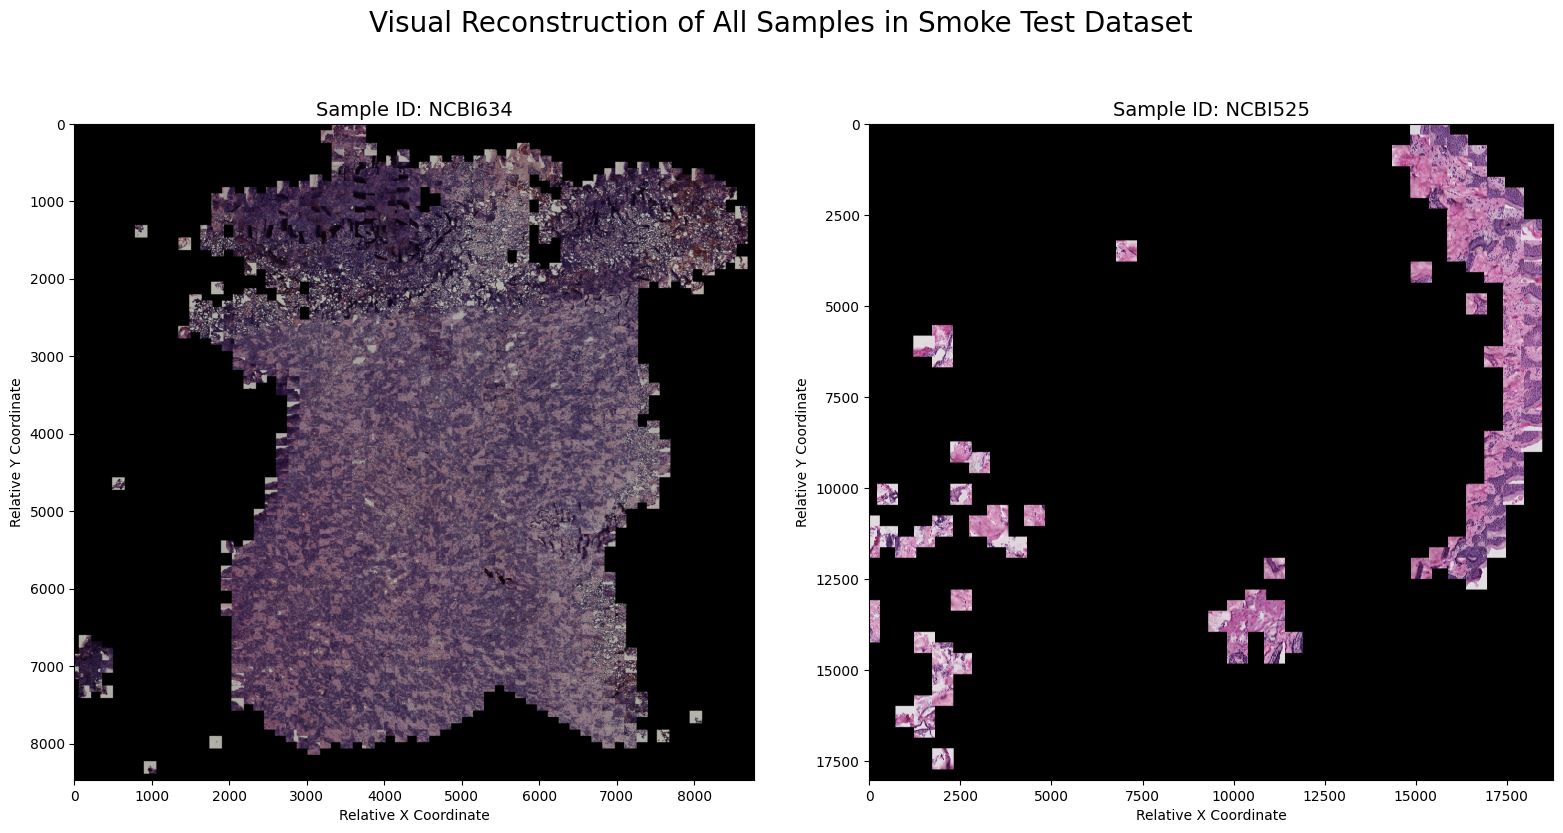

In [7]:
# ===== Cell 4: Visual Reconstruction and Validation (Multi-Sample SOTA Version) =====
# CodeGuardian: This cell provides the ultimate "proof" of dataset integrity.
# It now correctly handles multiple sample_ids by reconstructing each one on its own canvas,
# confirming that the spatial information for every sample in the subset is valid.

import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
from pathlib import Path
import logging

def reconstruct_slide_from_nodes_df(nodes_df: pd.DataFrame, sample_id_for_logging: str):
    """
    Reads a pandas DataFrame containing nodes for a SINGLE sample_id 
    and reconstructs its spatial arrangement of image tiles.

    Args:
        nodes_df: A DataFrame filtered to contain only nodes for one sample_id.
        sample_id_for_logging: The sample_id being processed, for clear logging.

    Returns:
        A PIL.Image object of the reconstructed slide, or None if an error occurs.
    """
    if nodes_df.empty:
        logging.warning(f"⚠️ DataFrame for sample '{sample_id_for_logging}' is empty. Cannot reconstruct.")
        return None

    # 1. Infer Tile Size from the first image
    try:
        first_image_path = nodes_df.iloc[0]['image_path']
        with Image.open(first_image_path) as first_tile:
            tile_w, tile_h = first_tile.size
        logging.info(f"[{sample_id_for_logging}] Inferred tile size: {tile_w}x{tile_h} pixels.")
    except Exception as e:
        logging.error(f"❌ [{sample_id_for_logging}] Could not open the first image tile to infer size: {e}")
        return None
        
    # 2. Calculate the bounding box for THIS SPECIFIC SAMPLE
    min_coord_x, max_coord_x = nodes_df['x'].min(), nodes_df['x'].max()
    min_coord_y, max_coord_y = nodes_df['y'].min(), nodes_df['y'].max()
    canvas_width = (max_coord_x - min_coord_x) + tile_w
    canvas_height = (max_coord_y - min_coord_y) + tile_h
    logging.info(f"[{sample_id_for_logging}] Calculated canvas size: {canvas_width}x{canvas_height} pixels.")
    
    canvas = Image.new('RGB', (canvas_width, canvas_height), 'black')
    
    # 3. Iterate and paste tiles for THIS SPECIFIC SAMPLE
    logging.info(f"[{sample_id_for_logging}] Reconstructing image from {len(nodes_df)} tiles...")
    for _, row in tqdm(nodes_df.iterrows(), total=len(nodes_df), desc=f"Pasting '{sample_id_for_logging}'"):
        try:
            with Image.open(row['image_path']) as tile:
                center_x, center_y = row['x'], row['y']
                top_left_x_abs = center_x - tile_w // 2
                top_left_y_abs = center_y - tile_h // 2
                paste_x = top_left_x_abs - min_coord_x
                paste_y = top_left_y_abs - min_coord_y
                canvas.paste(tile, (paste_x, paste_y))
        except FileNotFoundError:
            logging.warning(f"Skipping tile: image file not found at {row['image_path']}")
        except Exception as e:
            logging.warning(f"Skipping tile for sample '{sample_id_for_logging}' due to an error: {e}")
            
    return canvas

# --- Main Execution Block for Multi-Sample Reconstruction ---

# 1. Load the nodes data from the newly created smoke test set
nodes_file_path = SMOKE_TEST_DIR / "nodes.parquet"
if not nodes_file_path.exists():
    logging.error(f"❌ Nodes file not found at: {nodes_file_path}. Cannot perform reconstruction.")
else:
    final_nodes_df = pd.read_parquet(nodes_file_path)
    
    # 2. Identify all unique sample_ids in the smoke test set
    unique_sample_ids = final_nodes_df['sample_id'].unique()
    logging.info(f"\nFound {len(unique_sample_ids)} unique sample(s) in the smoke test set: {list(unique_sample_ids)}")
    
    reconstructed_images = []
    # 3. Loop through each sample_id and reconstruct it individually
    for sample_id in unique_sample_ids:
        logging.info(f"\n--- Processing reconstruction for sample: '{sample_id}' ---")
        # Filter the DataFrame for the current sample
        sample_df = final_nodes_df[final_nodes_df['sample_id'] == sample_id]
        
        # Call the reconstruction function on the filtered DataFrame
        reconstructed_image = reconstruct_slide_from_nodes_df(sample_df, sample_id)
        if reconstructed_image:
            reconstructed_images.append({'id': sample_id, 'image': reconstructed_image})

    # 4. Display all reconstructed images in a single plot for comparison
    if reconstructed_images:
        num_images = len(reconstructed_images)
        fig, axes = plt.subplots(1, num_images, figsize=(8 * num_images, 8), squeeze=False)
        fig.suptitle("Visual Reconstruction of All Samples in Smoke Test Dataset", fontsize=20, y=1.02)
        
        for i, result in enumerate(reconstructed_images):
            ax = axes[0, i]
            ax.imshow(result['image'])
            ax.set_title(f"Sample ID: {result['id']}", fontsize=14)
            ax.grid(False)
            ax.set_xlabel("Relative X Coordinate")
            ax.set_ylabel("Relative Y Coordinate")
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        logging.error("❌ Failed to generate any reconstructed images.")

In [6]:
final_nodes_df

NameError: name 'final_nodes_df' is not defined

2025-11-15 16:10:41,790 - INFO - ⚙️ Found 3 sample directories in Hydra smoke dataset.
2025-11-15 16:10:42,057 - INFO - [NCBI883] Tile size inferred from shard: 224x224.
2025-11-15 16:10:42,057 - INFO - [NCBI883] Tile size inferred from shard: 224x224.
2025-11-15 16:10:42,548 - INFO - [NCBI883] Reconstructing 1276 tiles from shard 'NCBI883_000000.tar'.
2025-11-15 16:10:42,548 - INFO - [NCBI883] Reconstructing 1276 tiles from shard 'NCBI883_000000.tar'.


Hydra paste NCBI883:   0%|          | 0/1276 [00:00<?, ?it/s]

2025-11-15 16:10:44,764 - INFO - [TENX157] Tile size inferred from shard: 224x224.
2025-11-15 16:10:46,434 - INFO - [TENX157] Reconstructing 4427 tiles from shard 'TENX157_000000.tar'.
2025-11-15 16:10:46,434 - INFO - [TENX157] Reconstructing 4427 tiles from shard 'TENX157_000000.tar'.


Hydra paste TENX157:   0%|          | 0/4427 [00:00<?, ?it/s]

2025-11-15 16:10:54,256 - INFO - [TENX158] Tile size inferred from shard: 224x224.
2025-11-15 16:10:55,107 - INFO - [TENX158] Reconstructing 2179 tiles from shard 'TENX158_000000.tar'.
2025-11-15 16:10:55,107 - INFO - [TENX158] Reconstructing 2179 tiles from shard 'TENX158_000000.tar'.


Hydra paste TENX158:   0%|          | 0/2179 [00:00<?, ?it/s]

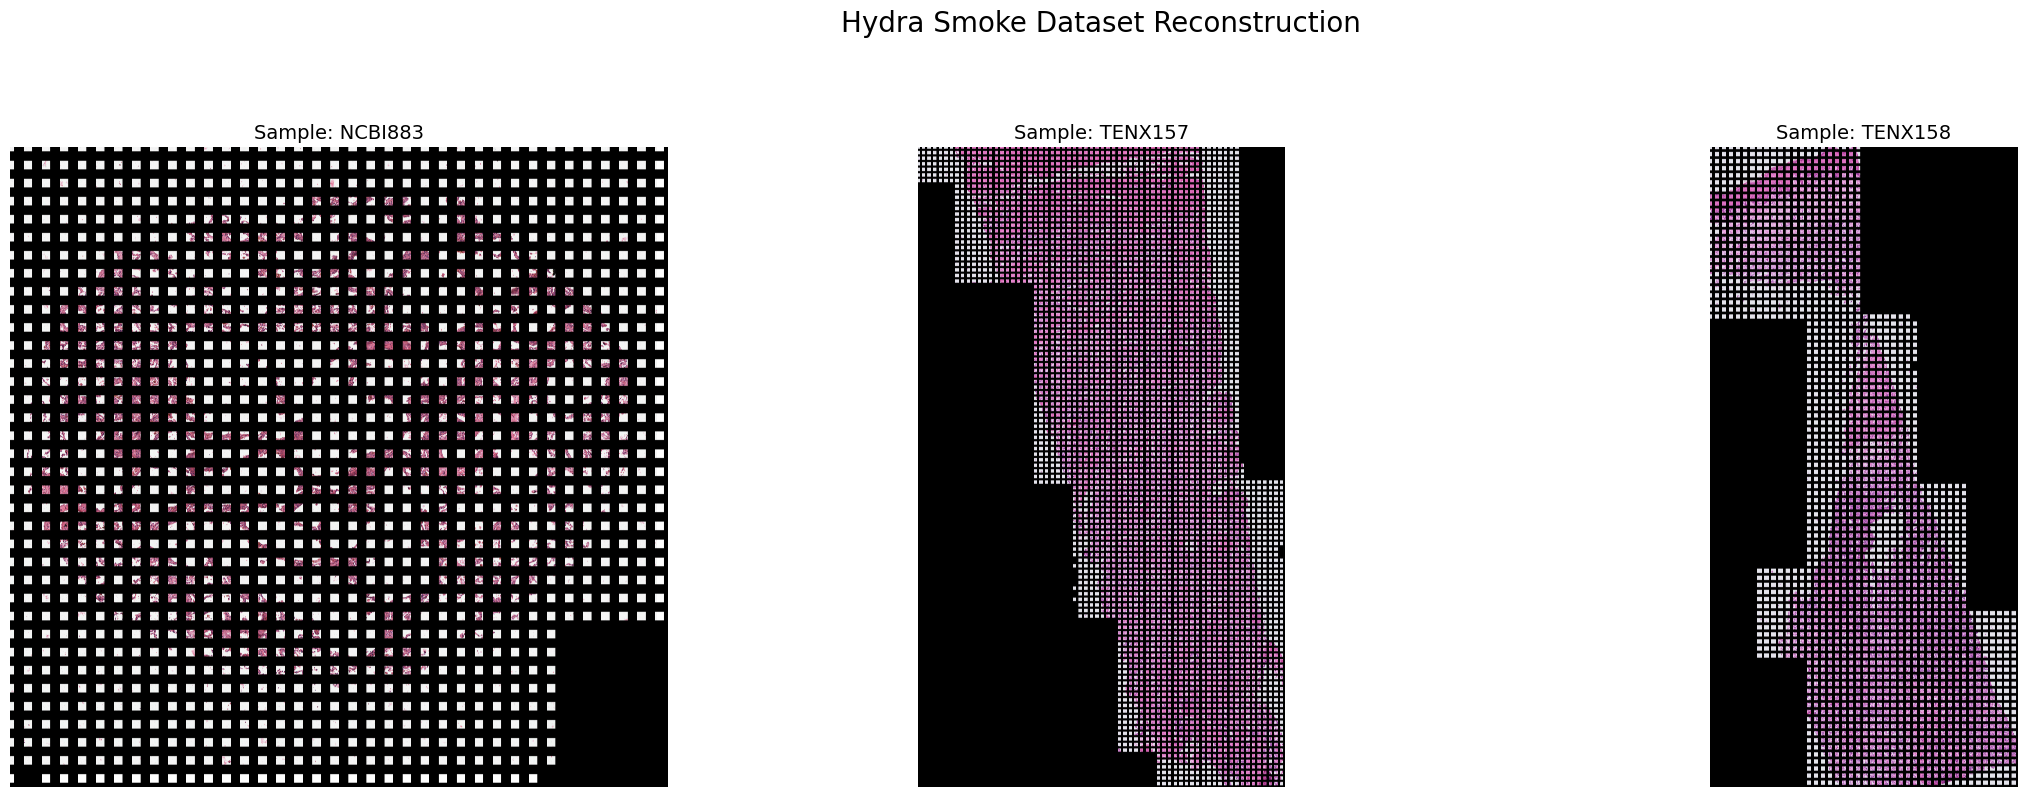

In [9]:
# ==============================================================================
# Step 7: Visual validation for Hydra-generated smoke dataset (WebDataset shards)
# ==============================================================================
import io
import json
import tarfile

HYDRA_SMOKE_DATASET_DIR = PROJECT_ROOT / "data/processed/hest_v1_smoke"


def _load_spots_from_shard(tar_path: Path):
    png_buffers = {}
    metadata = {}
    with tarfile.open(tar_path, "r:*") as shard:
        for member in shard:
            if not member.isfile():
                continue
            member_path = Path(member.name)
            key = member_path.stem
            suffix = member_path.suffix.lower()
            file_obj = shard.extractfile(member)
            if file_obj is None:
                continue
            if suffix == ".png":
                png_buffers[key] = file_obj.read()
            elif suffix == ".json":
                metadata[key] = json.load(file_obj)

    spots = []
    for key, meta in metadata.items():
        png_bytes = png_buffers.get(key)
        if png_bytes is None:
            continue
        spots.append(
            {
                "sample_id": meta.get("sample_id"),
                "x": int(meta.get("x", 0)),
                "y": int(meta.get("y", 0)),
                "png_bytes": png_bytes,
            }
        )
    return spots


def reconstruct_from_wds_shard(tar_path: Path, sample_id: str):
    spots = _load_spots_from_shard(tar_path)
    if not spots:
        logging.warning(f"[{sample_id}] Shard '{tar_path.name}' contained no usable records.")
        return None

    with Image.open(io.BytesIO(spots[0]["png_bytes"])) as first_tile:
        tile_w, tile_h = first_tile.size
    logging.info(f"[{sample_id}] Tile size inferred from shard: {tile_w}x{tile_h}.")

    xs = [spot["x"] for spot in spots]
    ys = [spot["y"] for spot in spots]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    canvas = Image.new(
        "RGB",
        ((max_x - min_x) + tile_w, (max_y - min_y) + tile_h),
        "black",
    )

    logging.info(f"[{sample_id}] Reconstructing {len(spots)} tiles from shard '{tar_path.name}'.")
    for spot in tqdm(spots, desc=f"Hydra paste {sample_id}", leave=False):
        tile = Image.open(io.BytesIO(spot["png_bytes"]))
        paste_x = spot["x"] - tile_w // 2 - min_x
        paste_y = spot["y"] - tile_h // 2 - min_y
        canvas.paste(tile, (paste_x, paste_y))
        tile.close()

    return canvas


if not HYDRA_SMOKE_DATASET_DIR.exists():
    logging.error(
        "❌ Hydra smoke dataset not found at %s. Run the preprocessing pipeline first.",
        HYDRA_SMOKE_DATASET_DIR,
    )
else:
    hydra_reconstructed = []
    sample_dirs = sorted(p for p in HYDRA_SMOKE_DATASET_DIR.iterdir() if p.is_dir())
    logging.info("⚙️ Found %d sample directories in Hydra smoke dataset.", len(sample_dirs))

    for sample_dir in sample_dirs:
        shard_candidates = sorted(sample_dir.glob("*.tar"))
        if not shard_candidates:
            logging.warning("[%s] No shards found under %s", sample_dir.name, sample_dir)
            continue
        shard_path = shard_candidates[0]
        recon_img = reconstruct_from_wds_shard(shard_path, sample_dir.name)
        if recon_img:
            hydra_reconstructed.append({"id": sample_dir.name, "image": recon_img})

    if hydra_reconstructed:
        cols = len(hydra_reconstructed)
        fig, axes = plt.subplots(1, cols, figsize=(8 * cols, 8), squeeze=False)
        fig.suptitle("Hydra Smoke Dataset Reconstruction", fontsize=20, y=1.02)

        for idx, result in enumerate(hydra_reconstructed):
            ax = axes[0, idx]
            ax.imshow(result["image"])
            ax.set_title(f"Sample: {result['id']}", fontsize=14)
            ax.axis("off")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        logging.error("❌ Hydra reconstruction failed: no images generated.")